## Overview


Following our section on data collection, we shift focus to analyzing social data. The course will now cover basic tools in Network and Text Analysis, applying these to previously collected data. We start with Network Science.

Networks, or graphs, are crucial for representing and analyzing social systems. This week introduces networks through three main topics:

* __Context__: An overview of network science history and basic network concepts.
* __The NetworkX Library__: Introduction to this Python library for network analysis.
* __Basic Network Analysis:__ We will analyze and visualize the network of Computational Social Scientists using NetworkX.
  
The objective is to ensure you learn about the field of network science and get hands-on experience using the NetworkX library for fundamental analysis.

# Part 1: Basic mathematical description of networks

This week, let's start with some lecturing. First, we will go through the history of Network Science. 

> **_Video Lecture_**. Start by watching the "History of Networks"

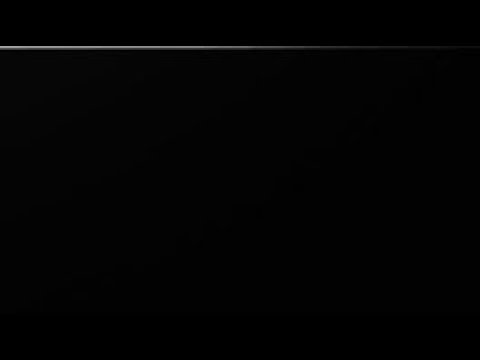

In [11]:
from IPython.display import YouTubeVideo
YouTubeVideo("kt6J36e0JCk",width=800, height=450)

> **_Video Lecture_**. Then check out a short video on "Network Notation"

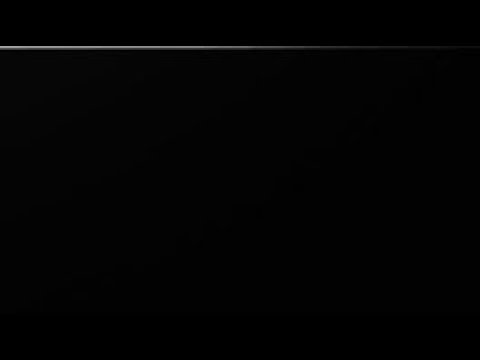

In [12]:
YouTubeVideo("_AT9HaTE9nE",width=800, height=450)

> __Reading__. To better familiarize with basic concepts in Network Science, we will read two chapters in the _Network Science_ book by Laszlo Barabasi. You can read the whole 
> book for free [**here**](http://barabasi.com/networksciencebook/). 
> 
> * [Read chapter 1](http://networksciencebook.com/chapter/1)
> * [Read chapter 2](http://networksciencebook.com/chapter/2)
> 

# Prelude to Part 2: The NetworkX library 

In this course, we will leverage the NetworkX Python library for network analysis. To effectively work with real-world networks, it is essential that you familiarize with NetworkX beforehand.

> __Exercise__
>
> * Download the NetworkX project's [tutorial](https://networkx.org/documentation/stable/tutorial_full.ipynb). Familiarize with the basics like creating graphs, accessing node and edge properties, and visualizing graphs.
> * Experiment with the tutorial code. Feel free to tweak it to understand how things work.

# Part 2: Basic analysis of the network of Computational Social Scientists

Ok, enough with theory. It is time to go back to our dataset. 
We will build the network of Computational Social Scientists. Then, we will use some Network Science to study some of its properties.

> **Exercise 1: Constructing the Computational Social Scientists Network**
>
> In this exercise, we will create a network of researchers in the field of Computational Social Science using the NetworkX library. In our network, nodes represent authors of academic papers, with a direct link from node _A_ to node _B_ indicating a joint paper written by both. The link's weight reflects the number of papers written by both _A_ and _B_.
>
> **Part 1: Network Construction**
>
> 1. **Weighted Edgelist Creation:** Start with your dataframe of *papers*. Construct a _weighted edgelist_ where each list element is a tuple containing three elements: the _author ids_ of two collaborating authors and the total number of papers they've co-authored. Ensure each author pair is listed only once. 
>
> 2. **Graph Construction:**
>    - Use NetworkX to create an undirected [``Graph``](https://networkx.org/documentation/stable/reference/classes/graph.html).
>    - Employ the [`add_weighted_edges_from`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_weighted_edges_from.html#networkx.Graph.add_weighted_edges_from) function to populate the graph with the weighted edgelist from step 1, creating a weighted, undirected graph.
>
> 3. **Node Attributes:**
>    - For each node, add attributes for the author's _display name_, _country_, _citation count_, and the _year of their first publication_ in Computational Social Science. This information should be retrieved from your _authors_ dataset. You can use the _papers_ dataset to retreive the total number of citations per author. 
>    - Save the network as a JSON file.
>      
> **Part 2: Preliminary Network Analysis**
> Now, with the network constructed, perform a basic analysis to explore its features.
> 1. **Network Metrics:**
>    - What is the total number of nodes (authors) and links (collaborations) in the network? 
>    - Calculate the network's density (the ratio of actual links to the maximum possible number of links). Would you say that the network is sparse? Justify your answer.
>    - Is the network fully connected (i.e., is there a direct or indirect path between every pair of nodes within the network), or is it disconnected?
>    - If the network is disconnected, how many connected components does it have? A connected component is defined as a subset of nodes within the network where a path exists between any pair of nodes in that subset. 
>    - How many isolated nodes are there in your network?  An isolated node is defined as a node with no connections to any other node in the network.
>    - Discuss the results above on network density, and connectivity. Are your findings in line with what you expected? Why? 
> 
> 3. **Degree Analysis:**
>    - Compute the average, median, mode, minimum, and maximum degree of the nodes. Perform the same analysis for node strength (weighted degree). What do these metrics tell us about the network?
> 
> 4. **Top Authors:**
>    - Identify the top 5 authors by degree. What role do these node play in the network? 
>    - Research these authors online. What areas do they specialize in? Do you think that their work aligns with the themes of Computational Social Science? If not, what could be possible reasons? 


Take the network of Computational Social Scientists you built in the exercise above.
To get an idea about how the network looks like, we start visualizing it. For this exercise, we will use the __awesome library [``netwulf``](https://netwulf.readthedocs.io/en/latest/index.html)__ created by Ulf Aslak and Ben Maier, two colleagues of mine. 
You can install it via ``pip install netwulf``. 

Netwulf is built on top of [d3-force](https://github.com/d3/d3-force), a Javascript library that simulates the dynamics of particles moving in 2D. In the visualization, particles correspond to network nodes subject to forces:
 * Nodes are attracted to the center of the viz 
 * Nodes repel each other
 * Nodes linked by an edge will preferably stay at a fixed distance to each other.

Come and ask me if you want to know more!

> __Exercise 2: Visualize the network of Computational Social scientists.__
>
> * Extract the [largest connected components](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html) from your network. The largest connected component is the one with the largest number of nodes. 
> * Visualize the largest connected component using the function [``visualize``](https://netwulf.readthedocs.io/en/latest/reference/interactive.html?highlight=visualize#netwulf.interactive.visualize) of the Netwulf package. 
> * Play with the parameters of the netwulf algorithm to obtain a visualization you like. To understand better what the parameters mean, have a look at the [documentation](https://netwulf.readthedocs.io/en/latest/visualization/init.html?). Your visualization may look similar to the one below, where I made the size of nodes proportional to their strength (sum of weights of incoming edges), and I added the names of the top Computational Social Scientists by degree... But not necessarily! Just have fun making your own version. You can save the figure directly from the interactive visualization panel, or plot it in higher resolution in matplotlib following [this example](https://netwulf.readthedocs.io/en/latest/cookbook/cookbook.html#save-as-pdf).
> * Describe the structure you observe. Can you identify nodes with a privileged position in the network?
> * _Optional_: You can color nodes based on a property of your interest (e.g. country, citations). For example, I colored nodes based on their country. What do you observe? Can you find specific nodes properties that seem to correlate with a node's position in the network?
>  
> **Note:** I encourage you to use Netwulf because they enable to make better visualizations, but you can also try to use the [draw](https://networkx.org/documentation/stable/reference/drawing.html) function built in NetworkX.
>
> __Go on [DTU Learn](https://learn.inside.dtu.dk/d2l/lms/survey/user/surveys_list.d2l?ou=187754) and complete the Survey: Week 4 - The Network__

<img src="https://raw.githubusercontent.com/lalessan/comsocsci2024/main/figures/network.png" alt="Drawing" style="width: 800px;"/>